## NLP Classification with PyTorch *(spam classification)*

* How to create a DataLoader on a custom Textual data in torch:

https://androidkt.com/create-dataloader-with-collate_fn-for-variable-length-input-in-pytorch/

* torchtext modeling
https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [361]:
import pandas as pd
import numpy as np
import seaborn as sn

import torch, torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

import torchtext
from torchtext import vocab
from torchtext.vocab import build_vocab_from_iterator

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from gensim.models import Word2Vec
import gensim

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [25]:
SEED = 100

torch.manual_seed(SEED)

### Data Loading

In [11]:
data = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')

In [12]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [14]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [17]:
X = data.v2
Y = data.v1
#Y = np.where(Y=='spam',1,0)
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [19]:
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify=Y, test_size=.15)

In [22]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
#Y_train.reset_index(drop=True,inplace=True)
#Y_test.reset_index(drop=True,inplace=True)


In [23]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4736,), (836,), (4736, 1), (836, 1))

In [405]:
type(X_train), type(Y_train)

(pandas.core.series.Series, numpy.ndarray)

### Torch DataLoader

In [402]:
"""
Below is the method to create a pytorch dataloader from a numpy data. 
But, here, in our case, we have a textual data. So, we have to follow a different path
"""

# x_train_dataset = torch.tensor(X_train.values.astype(np.float32))
# x_test_dataset = torch.tensor(X_test.values.astype(np.float32))

# y_train_dataset = torch.tensor(y_train.values.astype(np.float32))
# y_test_dataset = torch.tensor(y_test.values.astype(np.float32))

# train_dataset = data_utils.TensorDataset(x_train_dataset, y_train_dataset)
# test_dataset = data_utils.TensorDataset(x_test_dataset, y_test_dataset)

In [406]:
X_train_np= X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [407]:
type(X_train_np), type(X_test_np)

(numpy.ndarray, numpy.ndarray)

In [408]:
train_dataset = list(zip(X_train_np,Y_train))
test_dataset = list(zip(X_test_np,Y_test))

In [409]:
train_dataset[0:1]

[('Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)',
  array([1]))]

## 1. Training the Embeddings in the modeling and using vocab from the train data

In [410]:
tok = torchtext.data.utils.get_tokenizer("basic_english")

In [411]:
def yield_tokens(data_iter):
    for text,label in data_iter:
        yield tok(text)

In [412]:
#train_iter = iter(train_dataset)

In [612]:
vocab = build_vocab_from_iterator(yield_tokens(iter(X_train_dataset)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [945]:
vocab(tok('Kite')) ## this is for unknown

[0]

In [576]:
text_pipeline = lambda x: vocab(tok(x))

In [572]:
X_train_np[1]

'NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!'

In [591]:
tok(X_train_np[1])

['not',
 'much',
 'no',
 'fights',
 '.',
 'it',
 'was',
 'a',
 'good',
 'nite',
 '!',
 '!']

In [578]:
text_pipeline(X_train_np[1])

[33, 134, 47, 3221, 1, 16, 70, 8, 66, 535, 9, 9]

In [580]:
torch.tensor(text_pipeline(X_train_np[1]), dtype=torch.int64)

tensor([  33,  134,   47, 3221,    1,   16,   70,    8,   66,  535,    9,    9])

In [1186]:
cv=[]

In [1187]:
cv.append(torch.tensor(text_pipeline(X_train_np[702]), dtype=torch.int64))

In [1188]:
cv.append(torch.tensor(text_pipeline(X_train_np[1]), dtype=torch.int64))

In [1191]:
#cv

In [1194]:
pad_sequence(cv, batch_first=True, padding_value=0)

tensor([[  18,   15,   10,   76,  148,  339,   45, 4817,    1,    2,  148,  218,
           23,    2,   84,  105,  193,   77,  211,   15,    1,   95,  148,   39,
           10,  208,  228,  227,  611,   14,   17, 3883,    1,    2,  222,  339,
           10,   78,   12,  364,   16,   45,  105,    1,   95,  148,   39,   68,
          193,   77,    2,  850,    1,   76,   41,   39,   65,   51,   17,  193,
         2980,  119,  105,  288,    1,   17,  185,  148,  583,  211,  105,    1,
           17,  185,   41,   39, 3546,    3,  105,    1,    2,  222, 1522,   18,
          105,    1,   41,  150,   57,   17,  858,   12,  113,   57,  105, 7657,
            1,    2,   41,   39,  316,    3, 3220,   45,  727,   18,  105,    1,
            2,   41,   39,   14,   76,   51,    2,   41,   39,  166,   10, 5332,
          268,   18,  105,    1,   76,   41,   39,   51,    2,   92,    6,   38,
           22,    3, 7212,  727,   23,   17,  350,   13,   10,  489,  571, 1369,
           25,   10,  888, 3

In [1465]:
def collate_batch(batch):
    label_list, text_list = [],[]
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0) ## Padding
    ## Padding is w.r.t the batch. Every batch may have different padding size, hence, can have
    ## different length of the input token data
    ## Batch: True - Size of a token sentence will be based on the longest sentence in the batch. 
    ## Batch: False: Size of a token sentence will be of batch size, 16 in this case - 16
    return text_list, label_list

In [1466]:
batch_size = 16

In [1467]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [1468]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [1469]:
sdf=iter(train_dataloader)

In [1575]:
next(sdf)

(tensor([[   2,    6,   35,   14, 7640,    5, 1133,   40,    4,   81,  191,    7,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [1737,  735,  116, 8425,   15,    7,  180, 4808,   43, 8428,  246,    1,
           290,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [   4,  157,    6,   38,  572,   16,   32,   16,    6,   24,  475,    1,
            16,    6,   24, 3352,  821,    9,  103,  400,   26,    3, 1202, 2021,
          2145,  268,   23,   41, 2192,   19,  315,    1,   53, 3577,   75, 2740,
             0,    0],
         [  51,    4,   46,  430,   14,   10,  462, 1106,    5,  635,   17,  154,
            12,   10, 1623,   41,  495,    1,  158,    7,    0,    0,    0,    0,
             0,    0,    0,  

In [1197]:
# for x,y in train_dataloader:
#     print(x,"Target",y)
    

### Embedding vs Embeddingbag in PyTorch

* Both Embedding and EmbeddingBag generate a random weight embeddings in the beginning of the given size and dimension. These embedding weights are later training during the training process and the weights get updated in the backpropagation

In [732]:
embx = nn.Embedding(vocab_size, embed_dim, sparse=False)
embx

Embedding(8468, 64)

In [733]:
text_list=[]

processed_text1 = torch.tensor(text_pipeline(X_train_np[1]), dtype=torch.int64)
text_list.append(processed_text1)

processed_text2 = torch.tensor(text_pipeline(X_train_np[2]), dtype=torch.int64)
text_list.append(processed_text2)

In [734]:
text_list

[tensor([  33,  134,   47, 3221,    1,   16,   70,    8,   66,  535,    9,    9]),
 tensor([ 475, 6533,  106,  200,  630, 6792,   56, 8135,    1,  496, 7650, 1919,
          511, 3510,   51, 8171,   16,    1,   32,  118,   41, 5417, 8117,  401,
           51,  118,  339,  488,   16,    1])]

In [736]:
text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
text_list

tensor([[  33,  134,   47, 3221,    1,   16,   70,    8,   66,  535,    9,    9,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 475, 6533,  106,  200,  630, 6792,   56, 8135,    1,  496, 7650, 1919,
          511, 3510,   51, 8171,   16,    1,   32,  118,   41, 5417, 8117,  401,
           51,  118,  339,  488,   16,    1]])

In [737]:
embx(text_list).shape

torch.Size([2, 30, 64])

In [739]:
embx(text_list)[0] ## it's a a 30*64 array

tensor([[-0.9952, -1.6264, -0.2559,  ..., -0.8491, -1.0168,  0.9991],
        [ 0.5553, -1.5706, -0.2203,  ...,  2.1732, -0.3122, -1.2194],
        [-0.1269, -1.9645, -0.1128,  ...,  0.1804, -2.2760,  1.3937],
        ...,
        [-0.7064, -1.8527, -0.2557,  ...,  1.1743,  0.9795,  0.2450],
        [-0.7064, -1.8527, -0.2557,  ...,  1.1743,  0.9795,  0.2450],
        [-0.7064, -1.8527, -0.2557,  ...,  1.1743,  0.9795,  0.2450]],
       grad_fn=<SelectBackward0>)

In [741]:
embx(text_list).mean(dim=1)[0] ## Now, it's a 1*64 array

tensor([-0.4444, -1.4117, -0.2371,  0.4255,  2.1107,  0.5529,  0.6674, -0.6978,
        -0.2191, -1.7388,  0.8819, -0.6442,  0.0973,  0.3024,  0.3583, -0.9035,
        -0.0165,  0.6127, -1.1675,  0.4507, -0.6815, -1.2105, -0.6968, -0.5682,
         0.1605,  1.0999, -0.0432, -0.9071, -0.5351,  1.1902, -0.5123,  1.3209,
         0.4763, -0.6124,  0.1684,  0.2680,  0.5667,  0.1774, -0.1099, -0.2919,
        -0.9023, -0.2237, -0.5689, -0.0438,  0.9205,  0.0846,  0.4055,  0.5358,
        -0.6855,  0.6426, -0.1321,  0.1851,  0.7991,  0.8398,  0.2546, -0.2626,
         0.0650,  0.2703, -0.4582,  0.6604, -0.2320,  0.8000,  0.4171,  0.2303],
       grad_fn=<SelectBackward0>)

In [751]:
embx = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False, mode='mean') ## different modes like sum, mean, max, etc. are available for aggregation purpose
embx

EmbeddingBag(8468, 64, mode=mean)

In [752]:
embx(text_list).shape

torch.Size([2, 64])

In [753]:
embx(text_list)[0] ## it's a 1*64 array

tensor([ 0.1116,  0.3308, -0.6929, -1.2410,  0.1539,  0.1695,  0.4752, -0.1581,
        -0.6177,  0.2524,  0.7055, -0.4407, -0.2765,  0.1291, -0.0375,  0.6680,
        -0.0625,  0.9331, -0.1174,  0.3491,  0.1900, -0.9498,  0.2296,  1.1810,
         0.6015,  1.0510,  0.4102, -0.6386, -0.6421,  0.3748,  1.1630, -0.1038,
        -1.3850, -0.2195, -0.3011,  0.6117,  0.3008,  0.3845, -0.3874,  0.8779,
         0.5879, -0.2857, -0.6707,  0.0516,  0.6545, -0.4479, -1.4050, -0.2187,
        -0.2098,  0.3469,  0.1019, -0.3853,  0.3736, -0.5217,  0.1877,  0.0230,
        -0.7853, -0.6740,  1.1788, -1.4854, -1.0332,  0.0772,  0.1675, -0.6684],
       grad_fn=<SelectBackward0>)

* So, EmbeddingBag = Embedding + mean/mode operation to reduce the dimentionality or we can say to convert the embeddings of the words, in sentence, into single embedding representing the entire sentence

#### EmbeddingBag from Embedding

In [754]:
embx = nn.Embedding(vocab_size, embed_dim, sparse=False)
embx

Embedding(8468, 64)

In [755]:
embx_mean = nn.EmbeddingBag.from_pretrained(embx.weight, mode='mean')

In [758]:
embx_mean(text_list)[0]

tensor([ 0.0780,  1.3163,  0.1057, -0.3860,  0.1945, -0.0434,  0.2105, -0.0865,
        -0.5153, -1.0332, -1.1801,  0.6872,  0.5172, -0.7296,  0.9699, -0.0392,
        -0.2160,  0.8329, -0.1128, -0.4397, -0.3543, -0.6881, -0.2993, -0.8250,
        -0.4077,  0.3845, -0.2968,  0.6035,  0.3057,  0.9900,  0.0595, -0.7159,
         1.4818, -1.4228,  0.4024, -0.6619,  0.4771,  0.8957,  0.0659, -0.5520,
        -0.4291,  1.4420, -1.3561,  0.2162,  0.6934, -0.0391,  0.8906,  0.4168,
         0.1624,  0.0340, -0.0844,  1.7661, -0.0482, -0.0040,  0.2713, -0.3856,
         0.7205, -0.6521,  0.1869,  0.9983, -0.6650,  0.3693, -1.2855,  0.1522])

### Modeling

* **Model Architecture Diagram explaining how embeddingbag and vocab:**

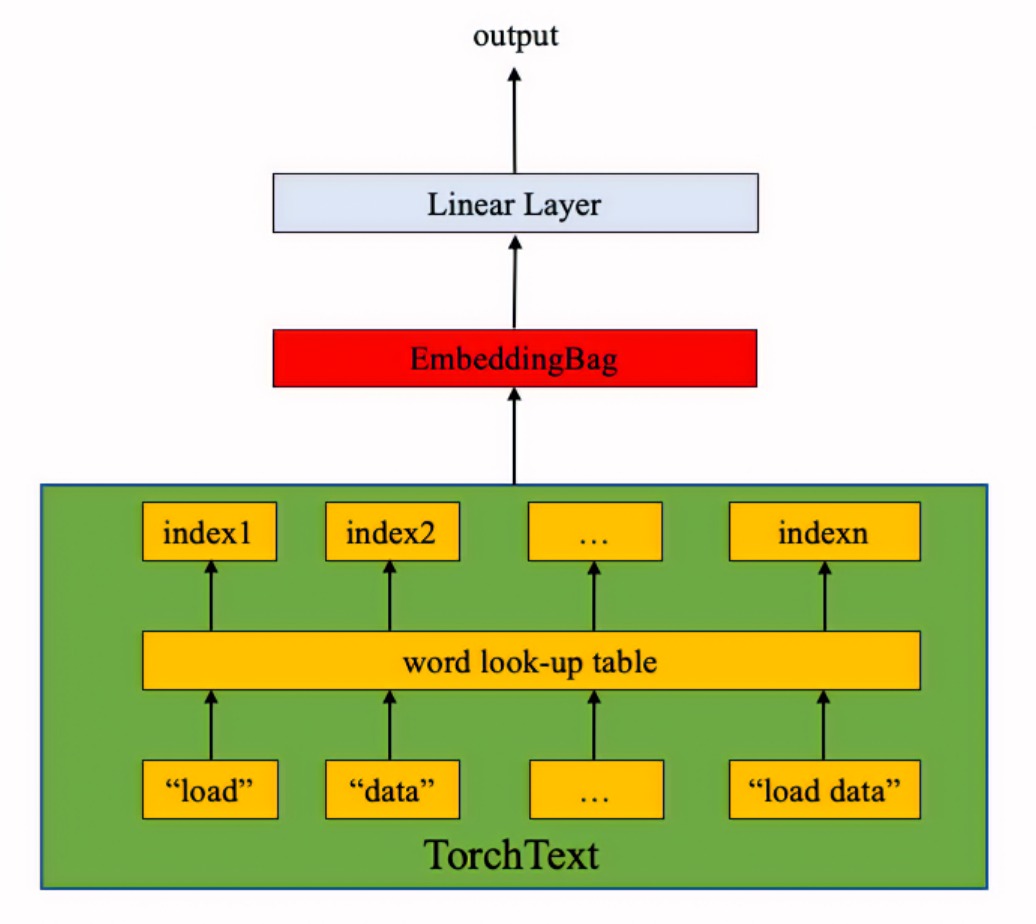

In [466]:
class TextClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False) ## this will create random values initially and then update the weights through back propagation
        ##self.embedding.from_pretrained(embeddings, freeze=True/False) ## in case you want to use some pretrained embeddings
        self.l1 = nn.Linear(embed_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,1)
        
    def forward(self,x):
        embedded = self.embedding(x)
        out = self.l1(embedded)
        out = self.relu1(out)
        out = self.l2(out)
        y_pred = torch.sigmoid(out)
        return y_pred            

### Model Parameters and Model Initiation

In [467]:
vocab_size = len(vocab)
embed_dim = 64
hidden_size = 256
learning_rate = .01
num_epochs=10
n_total_steps = len(train_dataloader)

In [468]:
vocab_size, n_total_steps

(8468, 296)

In [469]:
len(train_dataset)

4736

In [470]:
16*296 ## 16 is the batch_size and 296 is total number of batches

4736

In [471]:
mymodel = TextClassificationModel(vocab_size, embed_dim, hidden_size)

In [472]:
mymodel

TextClassificationModel(
  (embedding): EmbeddingBag(8468, 64, mode=mean)
  (l1): Linear(in_features=64, out_features=256, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=256, out_features=1, bias=True)
)

In [473]:
#mymodel.train()

In [474]:
criterion = nn.BCELoss() ## Binary Cross Entropy Loss
optimizer = torch.optim.Adam(mymodel.parameters(),lr = learning_rate)

### Model Training

In [475]:
count=0
writer = SummaryWriter()
for epoch in range(num_epochs):
    myloss = []
    for i,(x_data, labels) in enumerate(train_dataloader):
        count+=1
        y_predicted = mymodel(x_data) ## forward propagation
        
        loss = criterion(y_predicted,labels) ## loss calculation
        
        optimizer.zero_grad() ## Empty the gradients
        
        loss.backward() ## backward propagation
    
        optimizer.step() ## update the weights
        
        myloss.append(round(loss.item(),5))
        #if (i+1)%100 == 0:
        #    print(f'{epoch+1} of {num_epochs} ; step: {i+1} of {n_total_steps} ; loss = {loss.item():.4f}')
    print(f'Epoch {epoch+1} of {num_epochs}; Mean_Loss =  {round(np.mean(myloss),8)}')
    writer.add_scalar("Loss/train", np.mean(myloss), epoch)
writer.flush()
writer.close()

Epoch 1 of 10; Mean_Loss =  0.15370068
Epoch 2 of 10; Mean_Loss =  0.04300399
Epoch 3 of 10; Mean_Loss =  0.0228123
Epoch 4 of 10; Mean_Loss =  0.01087331
Epoch 5 of 10; Mean_Loss =  0.00618517
Epoch 6 of 10; Mean_Loss =  0.00683767
Epoch 7 of 10; Mean_Loss =  0.00508757
Epoch 8 of 10; Mean_Loss =  0.00727365
Epoch 9 of 10; Mean_Loss =  0.00476446
Epoch 10 of 10; Mean_Loss =  0.00478699


### Extract embeddings for any other task:
* Below is the 64 dimension embedding of 8468 words in our vocabulary

In [478]:
mymodel.embedding.weight.shape

torch.Size([8468, 64])

In [667]:
len(vocab.get_itos())

8468

In [674]:
vocab.get_itos()[14] ## The below embedding is of word 'in'

'in'

In [676]:
mymodel.embedding.weight[14]

tensor([-0.3262, -1.2964,  1.3518, -0.8946, -0.9105,  1.0702,  1.1080, -2.5218,
        -0.1124, -1.0304,  1.0143,  1.2746, -0.0799,  0.1216, -1.3660,  0.6125,
         1.7412, -0.5479,  0.2380, -1.5183, -0.3983,  1.2987, -0.1124, -0.5296,
        -0.7690,  0.3197,  0.3547, -0.1428, -0.2491, -1.4554,  0.0632, -0.0891,
         0.0821,  0.4911,  1.5706, -1.9940,  1.1055, -0.6574,  0.7047,  0.6483,
         1.0328, -1.1193,  1.1919,  0.4263, -0.1935,  0.6286,  1.3455, -2.3770,
         1.4434,  1.2389,  0.5429, -0.8945, -0.3742, -0.7228,  0.3968, -0.2780,
        -0.6540, -0.7577,  0.1471, -0.5486,  0.1843,  2.0084,  0.3602, -1.1925],
       grad_fn=<SelectBackward0>)

In [669]:
len(vocab.get_stoi())

8468

### Model Prediction

In [428]:
## Test Prediction
pred_list=[]
with torch.no_grad():
    for samples,labels in test_dataloader:
        outputs = mymodel(samples)
        
        predictions,_ = torch.max(outputs,1)
        predict_batch_list = list(predictions.detach().numpy())
        pred_list.append(predict_batch_list)
        
pred_list_final = list(itertools.chain(*pred_list))           

In [431]:
len(test_dataloader)

53

In [435]:
len(test_dataset)

836

In [436]:
16*52 ## and remaining 4 are in 53rd

832

In [437]:
outputs

tensor([[1.1990e-07],
        [1.5837e-19],
        [1.1170e-08],
        [9.9998e-01]])

In [438]:
pred_list_final

[4.642147e-08,
 4.5347163e-19,
 1.1027609e-14,
 3.372389e-16,
 8.9167335e-14,
 1.6249238e-10,
 4.9008274e-17,
 0.038446683,
 4.948838e-09,
 2.0715345e-13,
 2.9236025e-08,
 4.240701e-08,
 9.909261e-06,
 3.1489554e-07,
 3.566717e-13,
 1.3285997e-09,
 1.0,
 1.1450831e-11,
 1.2450491e-12,
 0.99999976,
 2.616451e-11,
 5.670584e-12,
 6.9511305e-14,
 7.180362e-26,
 6.6948286e-10,
 2.5052892e-14,
 3.925876e-12,
 2.6711938e-10,
 9.433058e-08,
 3.4536758e-06,
 2.4266747e-12,
 2.523091e-07,
 2.7907436e-07,
 1.4907676e-13,
 2.0261343e-10,
 8.6435637e-07,
 2.0042036e-13,
 1.4173843e-07,
 3.390455e-08,
 0.0004046701,
 1.0,
 1.0859098e-08,
 3.8557355e-11,
 1.3961843e-17,
 4.235656e-16,
 1.7753639e-22,
 1.6552998e-12,
 5.838954e-14,
 5.69236e-10,
 4.6555153e-13,
 8.2469353e-07,
 6.452796e-11,
 1.3064819e-11,
 1.0,
 0.9999893,
 0.3399428,
 0.00031731665,
 4.9955703e-14,
 1.9211222e-09,
 0.00021653392,
 1.0,
 5.2739724e-06,
 7.425961e-11,
 5.6912967e-21,
 5.5559804e-07,
 0.86052054,
 7.869655e-09,
 1.14

In [439]:
len(pred_list_final)

836

In [441]:
round(roc_auc_score(Y_test,pred_list_final),2)

0.97

In [456]:
np.around(pred_list_final[10:20],3), Y_test[10:20]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.], dtype=float32),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1]]))

## 2. using Pre-Trained Embeddings with Freeze=True/False
**(meaning training of its weights as true or false)**

* Best: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
* https://stackoverflow.com/questions/49710537/pytorch-gensim-how-to-load-pre-trained-word-embeddings

### (below code example is with GLoVe)

In [1894]:
embed_dim=300

In [1891]:
## you can also load vocab from existing models like Glove,etc.
glove_vocab = torchtext.vocab.GloVe(name='6B', dim=embed_dim) ## source: https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#GloVe

# and the rest is same

In [1892]:
glove_vocab

In [1893]:
glove_vocab.get_vecs_by_tokens('the')

tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8

#### We are using Gensim word2vec to get the tokens and idx of the words:

In [922]:


model = Word2Vec(sentences=X_train_processed, window=5, min_count=1, sg=0, vector_size =300)
#gensim model created
# w2v_model= gensim.models.Word2Vec(sentences = x_train,min_count=2,size=300,window=7,sg=0) 

In [924]:
len(model.wv.key_to_index) ## learned 3378 words

7110

In [788]:
tok(X_train[0])

['babe',
 'u',
 'want',
 'me',
 'dont',
 'u',
 'baby',
 '!',
 'im',
 'nasty',
 'and',
 'have',
 'a',
 'thing',
 '4',
 'filthyguys',
 '.',
 'fancy',
 'a',
 'rude',
 'time',
 'with',
 'a',
 'sexy',
 'bitch',
 '.',
 'how',
 'about',
 'we',
 'go',
 'slo',
 'n',
 'hard',
 '!',
 'txt',
 'xxx',
 'slo',
 '(',
 '4msgs',
 ')']

In [1636]:
for i, word in enumerate(model.wv.key_to_index):
    print(word)

to
you
the
and
is
in
me
it
my
for
your
call
of
have
that
on
now
are
can
so
but
not
or
we
at
be
get
if
do
will
ur
with
no
just
this
gt
lt
how
when
go
ok
free
up
from
what
all
out
ll
know
then
like
good
got
am
there
he
was
day
its
come
only
time
love
text
send
want
txt
one
as
going
need
by
home
don
about
stop
lor
sorry
our
still
she
see
back
mobile
today
da
reply
dont
her
pls
been
later
think
take
any
tell
hi
some
new
did
phone
they
week
has
please
re
i_
much
oh
where
dear
claim
well
hope
who
great
too
night
here
hey
wat
him
an
had
more
msg
yes
www
happy
way
should
number
message
give
tomorrow
work
won
right
make
ve
already
say
after
prize
doing
yeah
cash
ask
said
amp
find
very
babe
meet
them
cos
im
life
why
really
com
win
thanks
miss
let
nokia
also
uk
last
morning
every
min
lol
anything
something
before
urgent
over
pick
buy
care
again
first
wait
contact
sent
around
ya
off
late
leave
place
nice
keep
would
tone
help
feel
next
us
gonna
which
thing
even
sure
mins
his
box
service
money
went


#### Tokenize and basic cleaning of the input string

In [1823]:


def simple_prep_process( data): ## lowercases, tokenizes, and de-accents the text
        return data.apply(lambda x:  gensim.utils.simple_preprocess(x, deacc=True)) ## deacc is true to de-accent


In [1824]:
X_train_processed = simple_prep_process(X_train)

tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8

In [1829]:
# def key_index(sentence):
#     xy=[]
#     global myweight, vocab_len,sentence_tok
#     #print(sentence)
#     if len(sentence)>1:
#         for word in sentence:
#         #print (word)
#             try:
#                 myweight[glove_vocab.stoi[word]]=glove_vocab.get_vecs_by_tokens(word)
#             except:
#                 myweight[-1] = glove_vocab.get_vecs_by_tokens(word)
            
#             try:
#                 xy.append(glove_vocab.stoi[word])
#             except:
#                 xy.append(-1)
#         sentence_tok.append(xy)        

In [1830]:
train_vocab = model.wv.key_to_index

In [1895]:
train_vocab

{'to': 0,
 'you': 1,
 'the': 2,
 'and': 3,
 'is': 4,
 'in': 5,
 'me': 6,
 'it': 7,
 'my': 8,
 'for': 9,
 'your': 10,
 'call': 11,
 'of': 12,
 'have': 13,
 'that': 14,
 'on': 15,
 'now': 16,
 'are': 17,
 'can': 18,
 'so': 19,
 'but': 20,
 'not': 21,
 'or': 22,
 'we': 23,
 'at': 24,
 'be': 25,
 'get': 26,
 'if': 27,
 'do': 28,
 'will': 29,
 'ur': 30,
 'with': 31,
 'no': 32,
 'just': 33,
 'this': 34,
 'gt': 35,
 'lt': 36,
 'how': 37,
 'when': 38,
 'go': 39,
 'ok': 40,
 'free': 41,
 'up': 42,
 'from': 43,
 'what': 44,
 'all': 45,
 'out': 46,
 'll': 47,
 'know': 48,
 'then': 49,
 'like': 50,
 'good': 51,
 'got': 52,
 'am': 53,
 'there': 54,
 'he': 55,
 'was': 56,
 'day': 57,
 'its': 58,
 'come': 59,
 'only': 60,
 'time': 61,
 'love': 62,
 'text': 63,
 'send': 64,
 'want': 65,
 'txt': 66,
 'one': 67,
 'as': 68,
 'going': 69,
 'need': 70,
 'by': 71,
 'home': 72,
 'don': 73,
 'about': 74,
 'stop': 75,
 'lor': 76,
 'sorry': 77,
 'our': 78,
 'still': 79,
 'she': 80,
 'see': 81,
 'back': 82,
 'mo

#### Getting the embedding of each word in the vocabulary and also taking care of unknown words and padding

In [1831]:
matrix_len = len(train_vocab)
weight_matrix = np.zeros((matrix_len+2,embed_dim)) ## embed_dim is the size of each embedding ; ## +2 is for unknown words & other is for padding
words_found = 0

for i, word in enumerate(train_vocab):
        try:
            weight_matrix[i]=glove_vocab.get_vecs_by_tokens(word)
            words_found+=1
        except KeyError:
            weight_matrix[i]= np.random.normal(scale=0.6, size=(embedding_dim,))
            

In [1832]:
weight_matrix.shape

(7112, 300)

In [1833]:
weight_matrix[7110][0:5]

array([0., 0., 0., 0., 0.])

In [1834]:
weight_matrix[-1][0:5]

array([0., 0., 0., 0., 0.])

In [1835]:
list(train_vocab.keys())[list(train_vocab.values()).index(0)]

'to'

In [1836]:
glove_vocab.get_vecs_by_tokens('to')[0:3]

tensor([-0.2576, -0.0571, -0.6719])

In [1837]:
weight_matrix[0][0:3]

array([-0.25756001, -0.057132  , -0.67189997])

#### Getting token of each word in each sentence

In [1838]:
def word_tokens(sentence):
    sent_tok=[]
    for word in sentence:
        try:
            sent_tok.append(train_vocab[word])
        
        except:
            sent_tok.append(7110) # for Unkown words
    return sent_tok    

In [1839]:
sentence_tok=[]
sentence_tok=[word_tokens(sentence) for sentence in X_train_processed];

In [1840]:
word_tokens(['Hi']) ## For unknown words

[7110]

In [1841]:
train_vocab['to']

0

#### Padding and converting token data to torch

In [1842]:
text_list=[]
for sent_tok in sentence_tok:
    processed_text = torch.tensor(sent_tok, dtype=torch.int64)
    text_list.append(processed_text)   

#padding
text_list = pad_sequence(text_list, batch_first=True, padding_value=7111) 

In [1843]:
text_list[1]

tensor([  21,  107,   32, 2714,    7,   56,   51,  342, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111, 7111,
        7111, 7111, 7111, 7111, 7111, 71

#### Creating DataLoader

In [1845]:
label_list = torch.tensor(Y_train, dtype=torch.float32)

In [1846]:
train_embedding_dataset = list(zip(text_list,label_list))

In [1847]:
train_embedding_dataloader = DataLoader(train_embedding_dataset, batch_size=64)

In [1866]:
len(train_embedding_dataloader)

74

#### Converting weight matrix to tensor matrix

In [1848]:
weights_matrix_tensor = torch.tensor(weight_matrix, dtype=torch.float32)

## Modeling

In [1885]:
hidden_size = 256
learning_rate = .01
num_epochs=10
n_total_steps = len(train_embedding_dataloader)

In [1886]:
class TextClassificationEmbeddingModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super(TextClassificationEmbeddingModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False, mode='mean') ## this will create random values initially and then update the weights through back propagation
        self.embedding.from_pretrained(weights_matrix_tensor, freeze=False) # Freeze= True, no training of pretrained embedding weights
        self.l1 = nn.Linear(embed_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,1)
        
    def forward(self,x):
        embedded = self.embedding(x)
        out = self.l1(embedded)
        out = self.relu1(out)
        out = self.l2(out)
        y_pred = torch.sigmoid(out)
        return y_pred            

In [1887]:
mymodel_embedding = TextClassificationEmbeddingModel(weight_matrix.shape[0], embed_dim,hidden_size)

In [1888]:
mymodel_embedding

TextClassificationEmbeddingModel(
  (embedding): EmbeddingBag(7112, 300, mode=mean)
  (l1): Linear(in_features=300, out_features=256, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=256, out_features=1, bias=True)
)

In [1889]:
criterion = nn.BCELoss() ## Binary Cross Entropy Loss
optimizer = torch.optim.Adam(mymodel_embedding.parameters(),lr = learning_rate)

In [1890]:
count=0
#writer = SummaryWriter()
for epoch in range(num_epochs):
    myloss = []
    for i,(x_data, labels) in enumerate(train_embedding_dataloader):
        count+=1
        y_predicted = mymodel_embedding(x_data) ## forward propagation
        #print(y_predicted.shape)
        #print(labels.shape)
        loss = criterion(y_predicted,labels) ## loss calculation
        
        optimizer.zero_grad() ## Empty the gradients
        
        loss.backward() ## backward propagation
    
        optimizer.step() ## update the weights
        
        myloss.append(round(loss.item(),5))
        #if (i+1)%10 == 0:
        #    print(f'{epoch+1} of {num_epochs} ; step: {i+1} of {n_total_steps} ; loss = {loss.item():.4f}')
    print(f'Epoch {epoch+1} of {num_epochs}; Mean_Loss =  {round(np.mean(myloss),8)}')
    #writer.add_scalar("Loss/train", np.mean(myloss), epoch)
#writer.flush()
#writer.close()

Epoch 1 of 10; Mean_Loss =  0.40937676
Epoch 2 of 10; Mean_Loss =  0.16113054
Epoch 3 of 10; Mean_Loss =  0.03964243
Epoch 4 of 10; Mean_Loss =  0.0326227
Epoch 5 of 10; Mean_Loss =  0.030085
Epoch 6 of 10; Mean_Loss =  0.02837257
Epoch 7 of 10; Mean_Loss =  0.01975851
Epoch 8 of 10; Mean_Loss =  0.01029959
Epoch 9 of 10; Mean_Loss =  0.00550405
Epoch 10 of 10; Mean_Loss =  0.00517257
